<a href="https://colab.research.google.com/github/drorki/fish_tracking/blob/main/Few_Shot_ROI_Fish_Detection_TF_lite3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fine tuning of a SSD architecture (pre-trained on COCO) on very few examples of a novel class. We will then generate a (downloadable) TensorFlow Lite model for on-device inference.
This notebook is based on:
https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tflite.ipynb
, with some modifications, specifically on how to interpret the output of the generated model.

#Set Up

##Imports

In [ ]:
# Support for TF2 models was added after TF 2.3.
!pip install tf-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.0/589.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 KB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 KB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 73.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.15.0
    Uninstalling wrapt-1.15.0:
      Successfully uninstalled wrapt-1.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled 

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3691, done.
remote: Counting objects: 100% (3691/3691), done.
remote: Compressing objects: 100% (3078/3078), done.
remote: Total 3691 (delta 989), reused 1523 (delta 562), pack-reused 0
Receiving objects: 100% (3691/3691), 48.75 MiB | 16.44 MiB/s, done.
Resolving deltas: 100% (989/989), done.


In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-nightly 2.13.0.dev20230303 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.
tb-nightly 2.13.0a20230303 requires tensorboard-data-server<0.8.0,>=0.7.0, but you have tensorboard-data-server 0.6.1 which is incompatible.


This is a patch to make the project work with a later version of TF:

In [ ]:
pip install protobuf==3.20.*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached protobuf-3.20.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.0 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tb-nightly 2.13.0a20230303 requires tensorboard-data-server<0.8.0,>=0.7.0, but you have tensorboard-data-server 0.6.1 which is incompatible.


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.utils import config_util
from object_detection.builders import model_builder

%matplotlib inline

/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tensorflow1

##Utilities

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


# Fish data

We will start with data consisting of 16 images of fish.  Note that the [coco](https://cocodataset.org/#explore) dataset contains a number of animals, but notably, it does *not* contain fish, so this is a novel class.

In [ ]:
#Mount Google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#!ls /content/drive/MyDrive/Fish_Noise/single_fish/  # Old data
#!ls /content/drive/MyDrive/Fish_Noise/VIDEO_20230302_081012380_1FPS_ROI/  # New data with ROI
!ls /content/drive/MyDrive/Fish_Noise/VIDEO_20230304_100716744_1FPS_ROI/  # New data with ROI, clean container

frame0.jpg   frame16.jpg  frame22.jpg  frame29.jpg  frame35.jpg  frame4.jpg
frame10.jpg  frame17.jpg  frame23.jpg  frame2.jpg   frame36.jpg  frame5.jpg
frame11.jpg  frame18.jpg  frame24.jpg  frame30.jpg  frame37.jpg  frame6.jpg
frame12.jpg  frame19.jpg  frame25.jpg  frame31.jpg  frame38.jpg  frame7.jpg
frame13.jpg  frame1.jpg   frame26.jpg  frame32.jpg  frame39.jpg  frame8.jpg
frame14.jpg  frame20.jpg  frame27.jpg  frame33.jpg  frame3.jpg	 frame9.jpg
frame15.jpg  frame21.jpg  frame28.jpg  frame34.jpg  frame40.jpg


In [ ]:
N_TRAIN_IMAGES = 40  # Number of images for training

In [ ]:
import glob
#train_image_dir = '/content/drive/MyDrive/Fish_Noise/single_fish/' # Old data
test_image_dir = '/content/drive/MyDrive/Fish_Noise/VIDEO_20230223_133606599_1FPS_ROI/'  # New data with ROI (test)
train_image_dir = '/content/drive/MyDrive/Fish_Noise/VIDEO_20230304_100716744_1FPS_ROI/'  # New data with ROI, clean container (train)
file_list = glob.glob(train_image_dir + '*.jpg')
file_list = file_list[:N_TRAIN_IMAGES] # Use only 16 images for training
file_list
print('Number of files for training is', len(file_list))

Number of files for training is 40


In [ ]:
# Load images and visualize
train_images_np = []
for i in range(len(file_list)):
  #image_path = os.path.join(train_image_dir, 'robertducky' + str(i) + '.jpg')
  image_path = file_list[i]
  train_images_np.append(load_image_into_numpy_array(image_path))

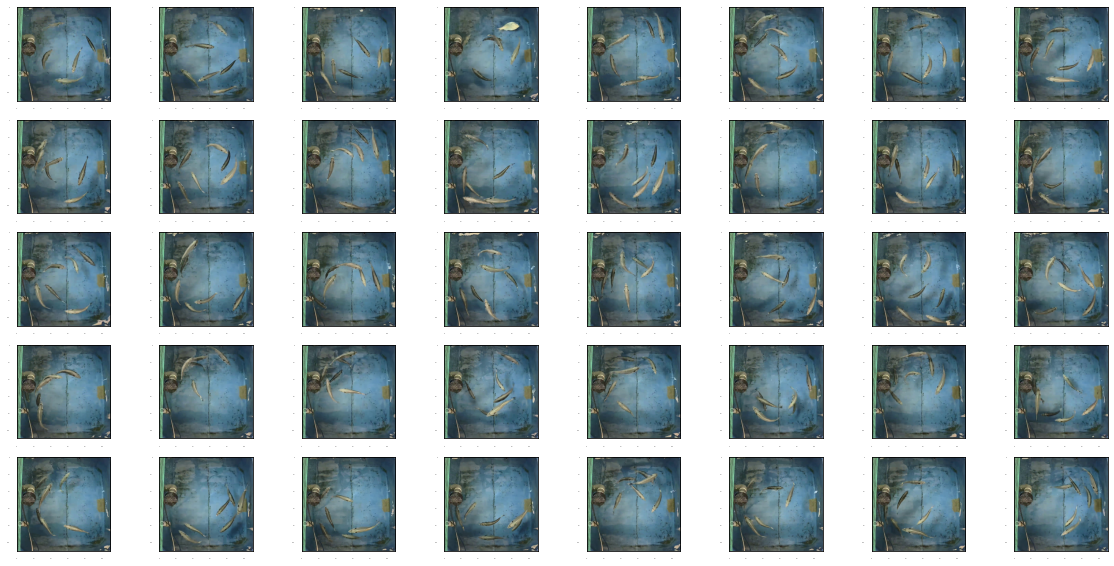

In [ ]:
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [20, 10]

for idx, train_image_np in enumerate(train_images_np):
  plt.subplot(5, 8, idx+1)
  plt.imshow(train_image_np)
plt.show()

# Annotate images with bounding boxes

In this cell we annotate --- draw a box around a fish in each image; click `next image` to go to the next image and `submit` when there are no more images.

If you'd like to skip the manual annotation step, we totally understand.  In this case, simply skip this cell and run the next cell instead, where we've prepopulated the groundtruth with pre-annotated bounding boxes.



In [ ]:
gt_boxes = []
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [ ]:
gt_boxes  # Show annotated gt_boxes

## In case you didn't want to label...

Run this cell only if you didn't annotate anything above and
would prefer to just use our preannotated boxes.  Don't forget
to uncomment.

In [ ]:
'''
# gt_boxes for 40 frames from VIDEO_20230304_100716744_1FPS_ROI
gt_boxes = [
    np.array([[0.41272222, 0.58090909, 0.70272222, 0.69636364]]),
    np.array([[0.65938889, 0.41      , 0.80105555, 0.65818182]]),
    np.array([[0.54272222, 0.30454545, 0.83272222, 0.38909091]]),
    np.array([[0.63772222, 0.29636364, 0.79105555, 0.55909091]]),
    np.array([[0.05272222, 0.71454545, 0.38438889, 0.83454545]]),
    np.array([[0.36438889, 0.42090909, 0.57272222, 0.62363636]]),
    np.array([[0.01438889, 0.40181818, 0.12772222, 0.74181818]]),
    np.array([[0.72438889, 0.32909091, 0.81438889, 0.71181818]]),
    np.array([[0.75438889, 0.49181818, 0.89605555, 0.75818182]]),
    np.array([[0.30938889, 0.20636364, 0.53438889, 0.35545455]]),
    np.array([[0.30605555, 0.30909091, 0.40272222, 0.55090909]]),
    np.array([[0.46605555, 0.49727273, 0.64438889, 0.76      ]]),
    np.array([[0.25272222, 0.3       , 0.49938889, 0.44909091]]),
    np.array([[0.56772222, 0.26545455, 0.82772222, 0.37636364]]),
    np.array([[0.30938889, 0.83454545, 0.61772222, 0.90818182]]),
    np.array([[0.64272222, 0.30636364, 0.73938889, 0.56181818]]),
    np.array([[0.54772222, 0.28909091, 0.76438889, 0.52636364]]),
    np.array([[0.49938889, 0.16909091, 0.78272222, 0.23818182]]),
    np.array([[0.30272222, 0.70363636, 0.63772222, 0.84090909]]),
    np.array([[0.55772222, 0.28      , 0.75105555, 0.42727273]]),
    np.array([[0.53438889, 0.38545455, 0.85772222, 0.47454545]]),
    np.array([[0.24105555, 0.27363636, 0.30438889, 0.61090909]]),
    np.array([[0.23438889, 0.29636364, 0.48105555, 0.38727273]]),
    np.array([[0.78105555, 0.19090909, 0.88272222, 0.45909091]]),
    np.array([[0.60272222, 0.21272727, 0.92438889, 0.33636364]]),
    np.array([[0.37272222, 0.33454545, 0.61272222, 0.47545455]]),
    np.array([[0.46605555, 0.37636364, 0.54772222, 0.66727273]]),
    np.array([[0.38438889, 0.22818182, 0.59438889, 0.33727273]]),
    np.array([[0.12772222, 0.58363636, 0.32438889, 0.74636364]]),
    np.array([[0.19772222, 0.81636364, 0.50605555, 0.88636364]]),
    np.array([[0.07105555, 0.29909091, 0.16272222, 0.58      ]]),
    np.array([[0.68105555, 0.28      , 0.77272222, 0.50272727]]),
    np.array([[0.26772222, 0.22545455, 0.57105555, 0.38454545]]),
    np.array([[0.60772222, 0.64909091, 0.80772222, 0.82454545]]),
    np.array([[0.80938889, 0.41545455, 0.87938889, 0.63818182]]),
    np.array([[0.82272222, 0.35909091, 0.88272222, 0.67363636]]),
    np.array([[0.36938889, 0.26636364, 0.58938889, 0.37909091]]),
    np.array([[0.29605555, 0.36181818, 0.36105555, 0.58272727]]),
    np.array([[0.34272222, 0.26090909, 0.61272222, 0.39545455]]),
    np.array([[0.29105555, 0.73545455, 0.55438889, 0.82636364]])
]
'''

In [ ]:
gt_boxes = gt_boxes[:N_TRAIN_IMAGES]
len(gt_boxes)

40

## Prepare data for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [ ]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
fish_class_id = 1
num_classes = 1

category_index = {fish_class_id: {'id': fish_class_id, 'name': 'fish'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


### Let's just visualize the fish as a sanity check - This don't work for multi boxes


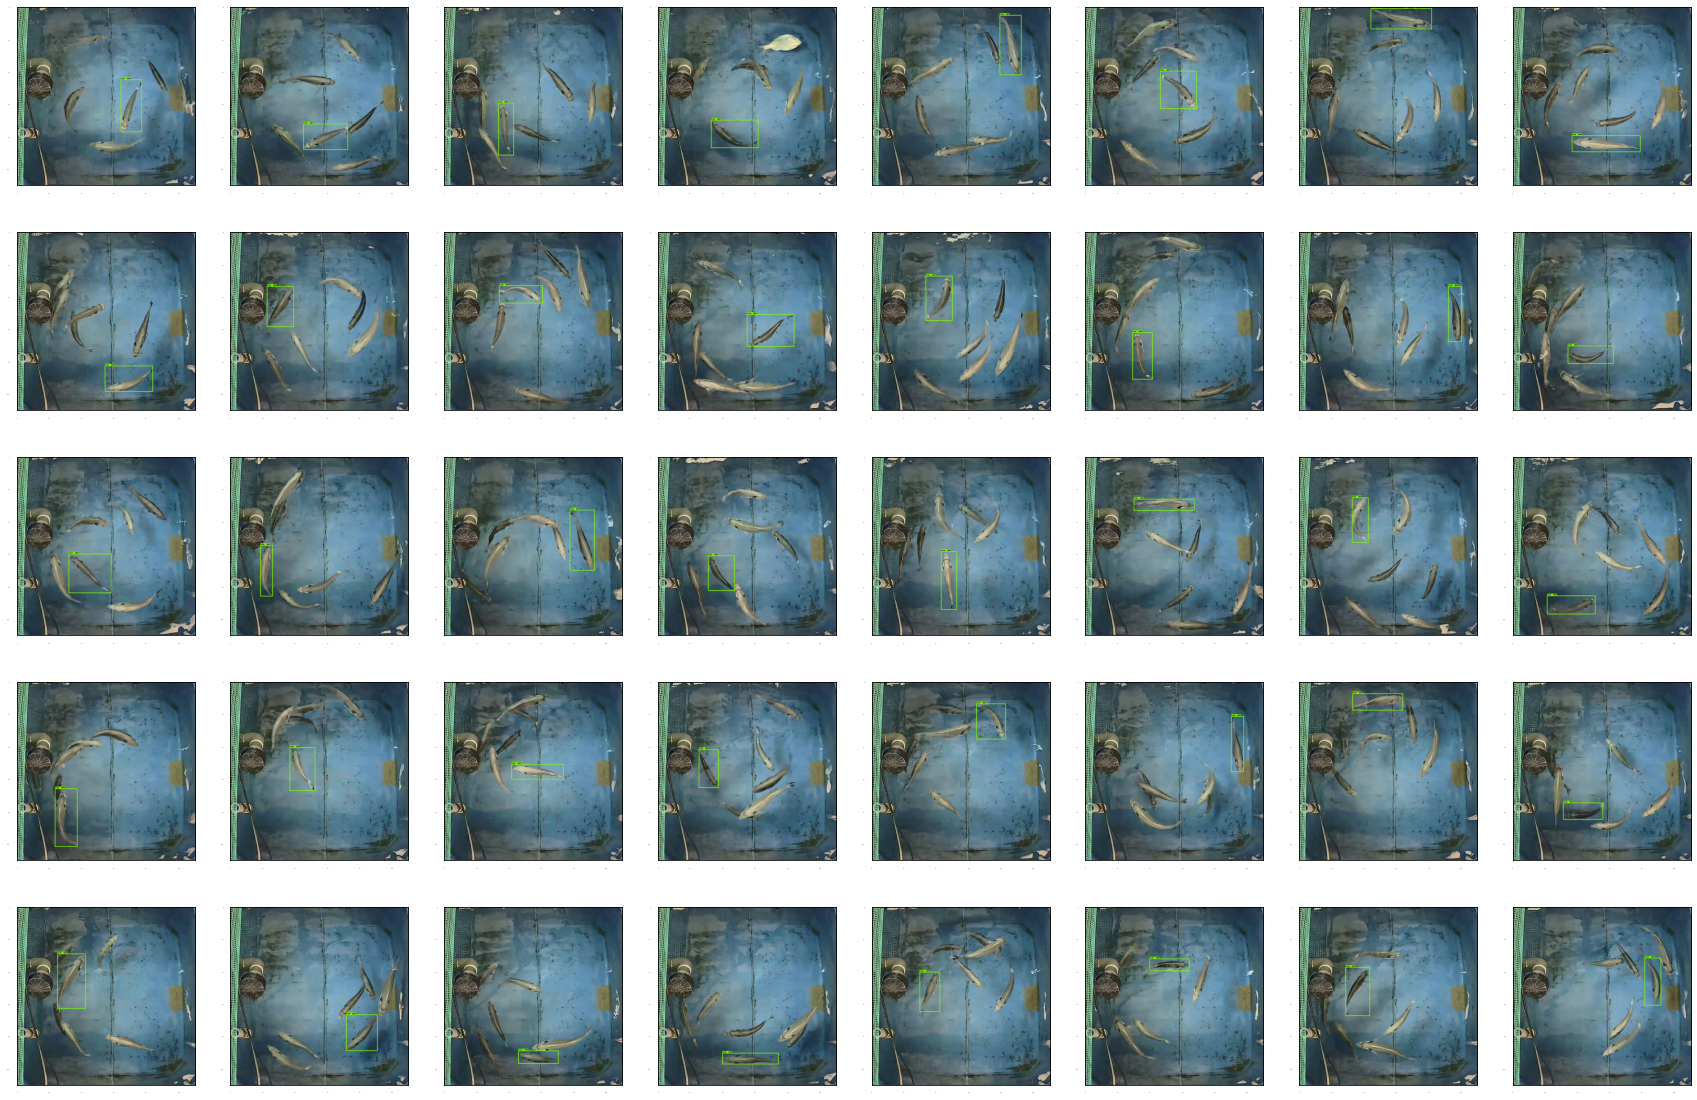

In [ ]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 20))
for idx in range(len(train_images_np)):
  plt.subplot(5, 8, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

#Transfer Learning

##Load mobile-friendly model

In this cell we build a mobile-friendly single-stage detection architecture (SSD MobileNet V2 FPN-Lite) and restore all but the classification layer at the top (which will be randomly initialized).

NOTE: TensorFlow Lite only supports SSD models for now.

For simplicity, we have hardcoded a number of things in this colab for the specific SSD architecture at hand (including assuming that the image size will always be 320x320), however it is not difficult to generalize to other model configurations (pipeline.config in the zip downloaded from the Model Zoo).


In [ ]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!tar -xf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!if [ -d "models/research/object_detection/test_data/checkpoint" ]; then rm -Rf models/research/object_detection/test_data/checkpoint; fi
!mkdir models/research/object_detection/test_data/checkpoint
!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2023-03-04 09:51:31--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.68.128, 2404:6800:4003:c04::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.68.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  --.-KB/s    in 0.09s   

2023-03-04 09:51:32 (219 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]



In [ ]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# This will be where we save checkpoint & config for TFLite conversion later.
output_directory = 'output/'
output_checkpoint_dir = os.path.join(output_directory, 'checkpoint')

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)
# Save new pipeline config
pipeline_proto = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(pipeline_proto, output_directory)

# Set up object-based checkpoint restore --- SSD has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# To save checkpoint for TFLite conversion.
exported_ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt_manager = tf.train.CheckpointManager(
    exported_ckpt, output_checkpoint_dir, max_to_keep=1)

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 320, 320, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


##Eager training loop (Fine-tuning)

Some of the parameters in this block have been set empirically: for example, learning_rate, num_batches & momentum for SGD. These are just a starting point, you will have to tune these for your data & model architecture to get the best results.

In [ ]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = N_TRAIN_IMAGES
learning_rate = 0.10 # originally was 0.15
num_batches = 3000 # originally was 1000

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 320x320.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[320, 320, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn



/usr/local/lib/python3.8/dist-packages/keras/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [ ]:
num_batches = 1000

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 100 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

ckpt_manager.save()
print('Checkpoint saved!')

Start fine-tuning!
batch 0 of 3000, loss=0.0038174
batch 100 of 3000, loss=0.003713437
batch 200 of 3000, loss=0.0036044442
batch 300 of 3000, loss=0.0035006464
batch 400 of 3000, loss=0.0034017111
batch 500 of 3000, loss=0.003307333
batch 600 of 3000, loss=0.0032172243
batch 700 of 3000, loss=0.0031311275
batch 800 of 3000, loss=0.0030488004
batch 900 of 3000, loss=0.0029700198
batch 1000 of 3000, loss=0.002894577
batch 1100 of 3000, loss=0.0028222809
batch 1200 of 3000, loss=0.002752955
batch 1300 of 3000, loss=0.0026864298
batch 1400 of 3000, loss=0.002622557
batch 1500 of 3000, loss=0.0025611892
batch 1600 of 3000, loss=0.0025021927
batch 1700 of 3000, loss=0.002445442
batch 1800 of 3000, loss=0.0023908222
batch 1900 of 3000, loss=0.0023382243
batch 2000 of 3000, loss=0.0022875445
batch 2100 of 3000, loss=0.0022386876
batch 2200 of 3000, loss=0.0021915662
batch 2300 of 3000, loss=0.0021460932
batch 2400 of 3000, loss=0.0021021902
batch 2500 of 3000, loss=0.0020597833
batch 2600 of 

#Export to run with TensorFlow Lite
##Model Conversion

First, we invoke the export_tflite_graph_tf2.py script to generate a TFLite-friendly intermediate SavedModel. This will then be passed to the TensorFlow Lite Converter for generating the final model.

To know more about this process, please look at: https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_on_mobile_tf2.md


In [ ]:
# Generate a TFLite-friendly intermadiate SavedModel
%%bash
python models/research/object_detection/export_tflite_graph_tf2.py \
  --pipeline_config_path output/pipeline.config \
  --trained_checkpoint_dir output/checkpoint \
  --output_directory tflite

2023-03-04 10:22:45.652845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by:

In [ ]:
# Use the TensorFlow Lite Converter to generate the final model
!tflite_convert --saved_model_dir=tflite/saved_model --output_file=tflite/model.tflite

2023-03-04 10:23:37.288683: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by:

##(Optional) Download model
This model can be run on-device with TensorFlow Lite. Look at our SSD model signature to understand how to interpret the model IO tensors:
The Object Detection example at: https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection is a good starting point for integrating the model into mobile app.

Refer to TFLite's inference documentation for more details: https://www.tensorflow.org/lite/guide/inference

In [ ]:
from google.colab import files
files.download('tflite/model.tflite') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Test .tflite model

In [ ]:
# Make a list of test images from test_image_dir
N_TEST_IMAGES = 20
file_list_test = glob.glob(test_image_dir + '*.jpg')
file_list_test = file_list_test[:N_TEST_IMAGES] # Use only N_TEST_IMAGES images for test
file_list_test
print('Number of files for testing is', len(file_list_test))

# Assign test images itno a list of tensors
#test_images_np = []
test_image_tensors = []
for i in range(len(file_list_test)):
  image_path = file_list_test[i]
  image = load_image_into_numpy_array(image_path)
  #test_images_np.append(image)
  test_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      image, dtype=tf.float32), axis=0))
  
test_images_np = test_image_tensors

Number of files for testing is 20


In [ ]:
#test_images_np = train_image_tensors

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()
input_tensor = tf.convert_to_tensor(test_images_np[0], dtype=tf.float32)
preprocessed_image, shapes = detection_model.preprocess(input_tensor)

In [ ]:
input_details = interpreter.get_input_details()
input_details

[{'name': 'serving_default_input:0',
  'index': 0,
  'shape': array([  1, 320, 320,   3], dtype=int32),
  'shape_signature': array([  1, 320, 320,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [ ]:
output_details = interpreter.get_output_details()
output_details

[{'name': 'StatefulPartitionedCall:1',
  'index': 339,
  'shape': array([ 1, 10], dtype=int32),
  'shape_signature': array([ 1, 10], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'StatefulPartitionedCall:3',
  'index': 337,
  'shape': array([ 1, 10,  4], dtype=int32),
  'shape_signature': array([ 1, 10,  4], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'StatefulPartitionedCall:0',
  'index': 340,
  'shape': array([1], dtype=int32),
  'shape_signature': array([1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32

In [ ]:
interpreter.set_tensor(input_details[0]['index'], preprocessed_image.numpy())
interpreter.invoke()

In [ ]:
scores = interpreter.get_tensor(output_details[0]['index'])
scores

array([[0.99728787, 0.9484789 , 0.9105568 , 0.44451582, 0.05941343,
        0.05788866, 0.04676927, 0.0454243 , 0.02317413, 0.02143304]],
      dtype=float32)

In [ ]:
boxes = interpreter.get_tensor(output_details[1]['index'])
boxes

array([[[ 0.63281417,  0.15478718,  0.94881773,  0.25574696],
        [ 0.70471096, -0.02865913,  0.99743474,  0.13665032],
        [ 0.8796074 ,  0.90898186,  0.99908227,  1.0142922 ],
        [-0.00685901, -0.02377196,  0.06552765,  0.1032736 ],
        [ 0.57841086,  0.14382073,  0.8965963 ,  0.22587174],
        [ 0.36280876,  0.6855171 ,  0.8292162 ,  0.90455294],
        [ 0.595406  ,  0.34022552,  0.9224611 ,  0.58400244],
        [ 0.862085  ,  0.14420399,  0.95592356,  0.45215043],
        [ 0.51385766,  0.12307458,  0.6406314 ,  0.18436037],
        [ 0.8433606 ,  0.18657766,  0.9336315 ,  0.23219968]]],
      dtype=float32)

In [ ]:
n_detections = interpreter.get_tensor(output_details[2]['index'])
n_detections

array([10.], dtype=float32)

In [ ]:
classes = interpreter.get_tensor(output_details[3]['index'])
classes

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
'''
Original detect function - we don't use it since it does not decode the interpreter's output properly


# Again, uncomment this decorator if you want to run inference eagerly
def detect(interpreter, input_tensor):
  """Run detection on an input image.

  Args:
    interpreter: tf.lite.Interpreter
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # We use the original model for pre-processing, since the TFLite model doesn't
  # include pre-processing.
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  interpreter.set_tensor(input_details[0]['index'], preprocessed_image.numpy())

  interpreter.invoke()

  boxes = interpreter.get_tensor(output_details[0]['index'])
  classes = interpreter.get_tensor(output_details[1]['index'])
  scores = interpreter.get_tensor(output_details[2]['index'])
  return boxes, classes, scores
'''

Explore the format of the interpreter's output:

In [ ]:
# This informative illustration is based on:
# https://stackoverflow.com/questions/68052773/how-to-retrieve-the-image-output-from-tensorflowlite-interpreter

# Load the TFLite model in TFLite Interpreter
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")  # interpreter = tf.lite.Interpreter(TFLITE_FILE_PATH)

# Print signature information to find out the input/output names.
signature_defs = interpreter.get_signature_list()
print(signature_defs)

# my_signature is callable with input as arguments.
my_signature = interpreter.get_signature_runner()
#input_tensor = test_images_np[0] #TDOD: reshape to 320x320x3
input_tensor = tf.convert_to_tensor(test_images_np[0], dtype=tf.float32)

output = my_signature(input=input_tensor[:,:320,:320,:])

# 'output' is dictionary with all outputs from the inference.
print(output)

print('output[''output_0''] is the number of detected objects:', 'output[''output_0''] =', output['output_0'])
print()

print('output[''output_1''] are the probabilities:', 'output[''output_1''] =', output['output_1'])
print()

print('output[''output_2''] is the class assigned to each object:', 'output[''output_2''] =', output['output_2'])
print()

print('output[''output_3''] is an array holding the bounding boxes for detected objects:', 'output[''output_3''].shape =', output['output_3'].shape)
print()

{'serving_default': {'inputs': ['input'], 'outputs': ['output_0', 'output_1', 'output_2', 'output_3']}}
{'output_0': array([10.], dtype=float32), 'output_1': array([[0.9999993 , 0.9997478 , 0.9995216 , 0.99672264, 0.9946582 ,
        0.99218196, 0.9865588 , 0.96968013, 0.9625868 , 0.89957315]],
      dtype=float32), 'output_2': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32), 'output_3': array([[[-0.04696018,  0.04299725,  0.20750546,  0.24458382],
        [ 0.7056898 ,  0.07477296,  1.0064193 ,  0.27660617],
        [ 0.7219911 ,  0.0351283 ,  1.019374  ,  0.20847307],
        [ 0.7031009 ,  0.1643079 ,  0.97428167,  0.3944431 ],
        [-0.02326929, -0.0011379 ,  0.15487397,  0.21923323],
        [ 0.5946289 ,  0.1039184 ,  1.0137571 ,  0.2604422 ],
        [ 0.6259855 ,  0.07400234,  1.0375906 ,  0.22849385],
        [ 0.7920044 , -0.03342601,  1.0102623 ,  0.24250111],
        [-0.04065572,  0.9637097 ,  0.19199319,  1.0317351 ],
        [ 0.7707375 , -0.0073947 ,

###Illustrate detection with the TFLite model:

In [ ]:
# Following the above, we rewrite the detect function such that:
# output_details[0]['index'] --> scores
# output_details[1]['index'] --> boxes
# output_details[3]['index'] --> classes

def detect(interpreter, input_tensor):
  """Run detection on an input image.

  Args:
    interpreter: tf.lite.Interpreter
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # We use the original model for pre-processing, since the TFLite model doesn't
  # include pre-processing.
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  interpreter.set_tensor(input_details[0]['index'], preprocessed_image.numpy())

  interpreter.invoke()
  
  scores = interpreter.get_tensor(output_details[0]['index'])
  boxes = interpreter.get_tensor(output_details[1]['index'])
  n_detections = interpreter.get_tensor(output_details[2]['index'])
  classes = interpreter.get_tensor(output_details[3]['index'])

  detections = {'boxes':boxes, 'scores':scores, 'classes':classes, 'n_detections': n_detections}
  return detections

In [ ]:
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()
#input_tensor = tf.convert_to_tensor(test_images_np[0], dtype=tf.float32)
#preprocessed_image, shapes = detection_model.preprocess(input_tensor)

Image # 1 ---------------
box = [0.63281417 0.15478718 0.94881773 0.25574696]
box = [ 0.70471096 -0.02865913  0.99743474  0.13665032]
box = [0.8796074  0.90898186 0.99908227 1.0142922 ]
box = [-0.00685901 -0.02377196  0.06552765  0.1032736 ]
Image # 2 ---------------
box = [-0.01088521  0.03424898  0.8383157   1.0291808 ]
box = [-0.0093928   0.01270848  0.43400115  0.13918024]
box = [0.5273231  0.19643345 0.7948178  0.26688343]
box = [ 0.7089452  -0.01924453  1.0215904   0.1264924 ]
box = [0.33373648 0.29886734 0.66982037 0.3751343 ]
box = [-0.01750249 -0.03039451  0.05885567  0.10021088]
box = [0.01770871 0.34788215 0.13007385 0.67092943]
box = [0.66259253 0.5220213  0.85327065 0.7049196 ]
box = [0.52367467 0.11891265 0.77829355 0.20107688]
box = [ 0.67684036 -0.02949355  0.75842375  0.11665579]
Image # 3 ---------------
box = [ 0.7414964  -0.00964316  1.011503    0.15000108]
box = [0.50146574 0.6716191  0.7204843  0.85967916]
box = [-0.01802589 -0.02781812  0.05851758  0.10728962]
bo

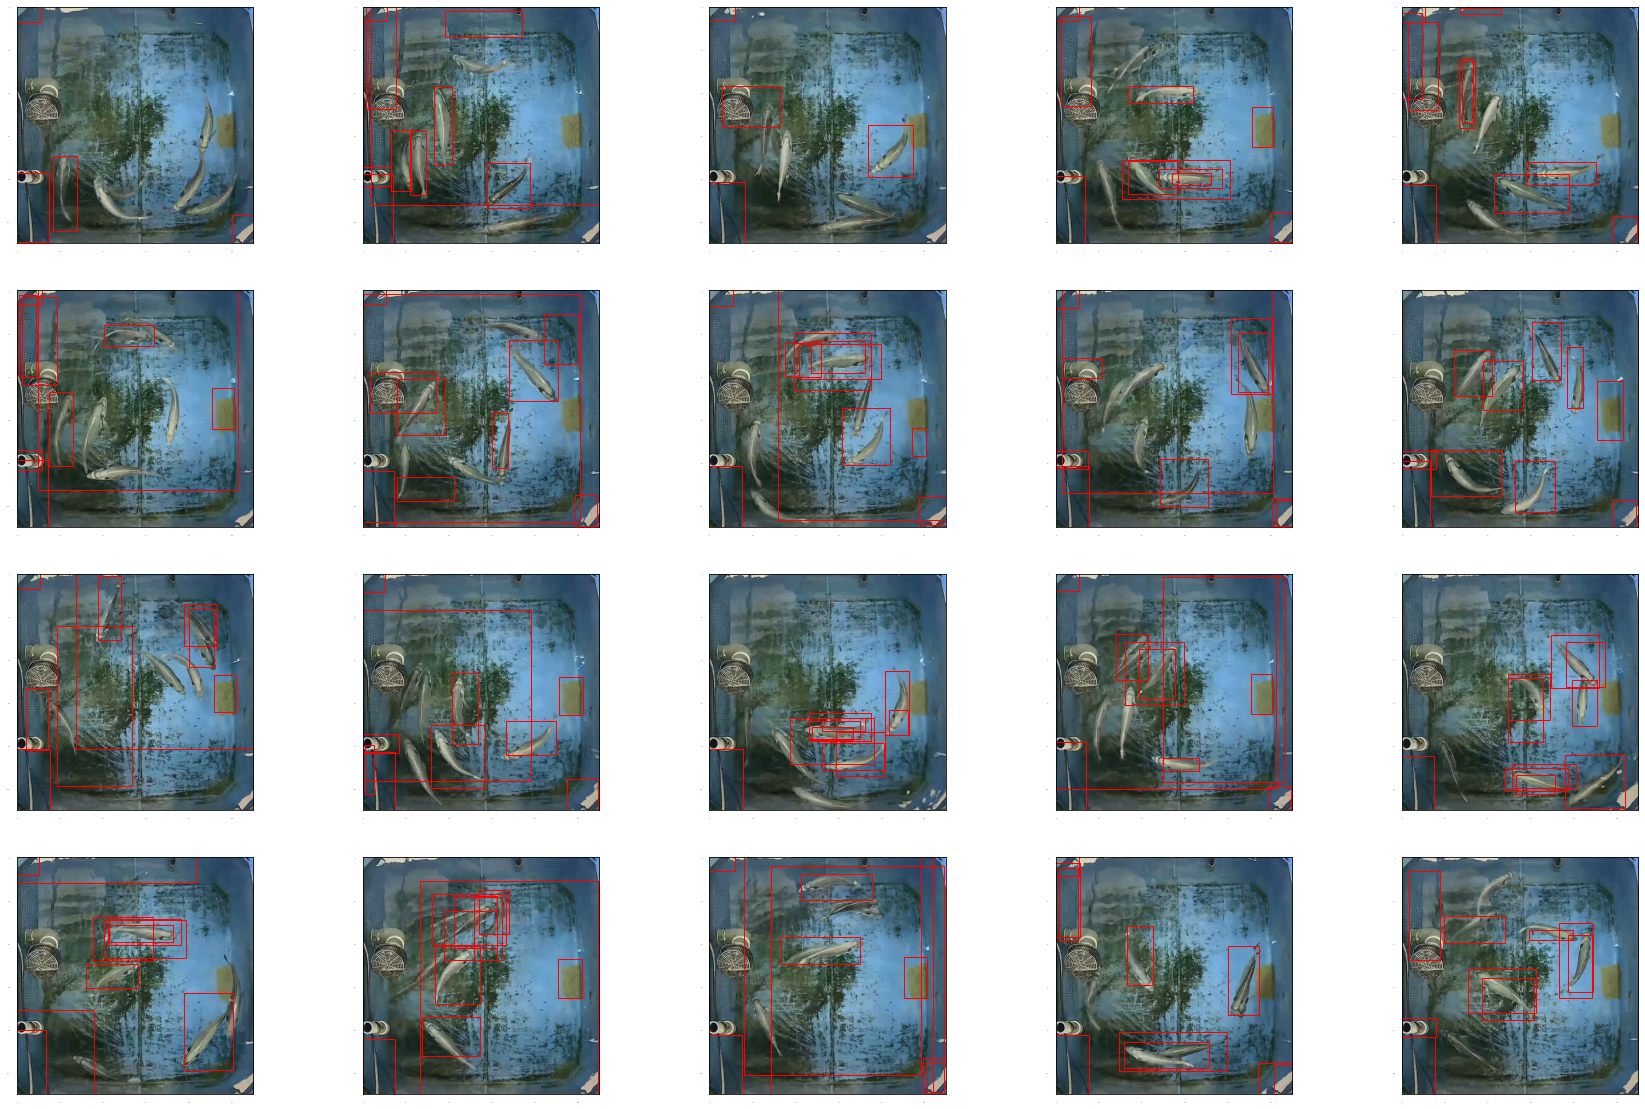

In [ ]:
from matplotlib.patches import Rectangle

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

plt.figure(figsize=(30, 20))

for image_idx in range(min(len(test_images_np), 20)):
  print('Image #', image_idx+1, '---------------')
  input_tensor = tf.convert_to_tensor(test_images_np[image_idx], dtype=tf.float32)
  detections = detect(interpreter, input_tensor)
  image_h = test_images_np[image_idx][0].shape[0]
  image_w =  test_images_np[image_idx][0].shape[1]

  plt.subplot(4, 5, image_idx+1)
  plt.imshow(test_images_np[image_idx][0]/255)
  ax = plt.gca()  # Reference to the current axis

  detected_boxes = np.where(detections['scores']>0.1)
  for ind in detected_boxes[1]:
    box = detections['boxes'][0,ind]  # box should be [TLy, TLx, BRy, BRx]
    rect_top_left = (box[1]*image_w, box[0]*image_h)  # Top-left corner of the rectangle plotted on the image
    rect_w = (box[3]-box[1])*image_w  # Width of rectangle plotted on image
    rect_h = (box[2]-box[0])*image_h  # height of rectangle plotted on image
    print('box =', box)
    #print('rectangle = [', rect_top_left, ',', rect_w, ',', rect_h, ']')
    rect = Rectangle(rect_top_left, rect_w, rect_h, linewidth=1,edgecolor='r',facecolor='none')  # Create a Rectangle patch
    ax.add_patch(rect)

plt.show()